[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1t3qATyF3eXuJhNJoHmo31fQ1hEig24-g#scrollTo=kY3rgaujvsdh)

## Problem Statement
Fine-tuning LLMs on domain-specific tasks enhances their performance in real-world applications. This project involves selecting a dataset, model, and fine-tuning framework to adapt a base model for medical reasoning, an essential use case in healthcare AI systems.

### Dataset: FreedomIntelligence/medical-o1-reasoning-SFT
-  Domain Relevance:
  - The dataset contains clinically relevant questions and answers, making it highly applicable to real-world healthcare use cases such as diagnostic support, triage assistants, and Q&A bots.
- Instruction-Based Format:
  - Each entry is structured with instruction, input, and output fields, which are essential for instruction-tuned LLMs and compatible with libraries like Unsloth.
- Reasoning-Oriented:
  - The tasks emphasize multi-step reasoning, explanation, and critical thinking rather than simple factual recall, matching the capabilities of LLMs like Mistral.
- SFT-Ready:
  - Designed for supervised fine-tuning, the dataset is plug-and-play with SFTTrainer and FastLanguageModel, reducing preprocessing time.
- Educational and Research Value:
 - The dataset is ideal for research and development of safe, interpretable AI in the medical field.

In summary, this dataset empowers the model to learn domain-specific reasoning patterns essential for trusted healthcare applications.


### Model: Mistral-7B v0.3 (7B)
- Balance of size and performance:
  - 7B parameters allow for solid reasoning capabilities while still trainable on consumer GPUs with LoRA.
- 2.2x faster inference:
  - Version 0.3 is optimized for performance, accelerating both training and deployment.
- Open-source and modifiable:
  - Ideal for experimentation, academic projects, and low-cost deployment.
- Strong performance on instruction-following tasks, making it ideal for the dataset’s format.


### Fine-Tuning Library: Unsloth
- Memory-Efficient:
  - Supports 4-bit/8-bit quantization and LoRA to significantly reduce memory usage.
- Fast Training:
  - Optimized training pipelines can be up to 2x faster than traditional Transformer workflows.
- Integrated with Hugging Face: Works seamlessly with Hugging Face models, tokenizers, and datasets.
- Simple API:
  - The FastLanguageModel and SFTTrainer abstractions reduce code complexity and support rapid prototyping.


### Summary
This approach enables a fast, memory-efficient fine-tuning pipeline to specialize a general-purpose LLM into a healthcare-focused assistant using the powerful Mistral model and Unsloth library. The selected components balance performance, efficiency, and ease of use, making them well-suited for this assignment and real-world deployment.

### Environment Setup

In [ ]:
# Installation
%%capture

import os

# Check if running in Google Colab to install necessary packages
if "COLAB_" not in "".join(os.environ.keys()):
    !pip install unsloth
else:
    # Do this only in Colab notebooks! Otherwise use pip install unsloth
    !pip install --no-deps bitsandbytes accelerate xformers==0.0.29.post3 peft trl==0.15.2 triton cut_cross_entropy unsloth_zoo
    !pip install sentencepiece protobuf "datasets>=3.4.1" huggingface_hub hf_transfer
    !pip install --no-deps unsloth
    !pip install --upgrade unsloth

In [ ]:
# Load Unsloth Model
from unsloth import FastLanguageModel
import torch

max_seq_length = 2048 # Choose any! We auto support RoPE Scaling internally!
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.

# 4bit pre quantized models we support for 4x faster downloading + no OOMs.
fourbit_models = [
    "unsloth/mistral-7b-bnb-4bit",
    "unsloth/mistral-7b-instruct-v0.2-bnb-4bit",
    "unsloth/llama-2-7b-bnb-4bit",
    "unsloth/llama-2-13b-bnb-4bit",
    "unsloth/codellama-34b-bnb-4bit",
    "unsloth/tinyllama-bnb-4bit",
    "unsloth/gemma-7b-bnb-4bit", # New Google 6 trillion tokens model 2.5x faster!
    "unsloth/gemma-2b-bnb-4bit",
    ] # More models at https://huggingface.co/unsloth

# Load pre-trained Mistral-7B model in 4-bit mode
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/mistral-7b-instruct-v0.3-bnb-4bit",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
    # token = "hf_...", # use one if using gated models like meta-llama/Llama-2-7b-hf
    )

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.5.7: Fast Mistral patching. Transformers: 4.51.3.
   \\   /|    NVIDIA A100-SXM4-40GB. Num GPUs = 1. Max memory: 39.557 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 8.0. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/4.14G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/157 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/141k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/587k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/446 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

### Inference Setup

In [ ]:
from unsloth.chat_templates import get_chat_template
from transformers import TextStreamer

# Setup chat template
tokenizer = get_chat_template(
    tokenizer,
    chat_template = "mistral", # Supports zephyr, chatml, mistral, llama, alpaca, vicuna, vicuna_old, unsloth
    mapping = {"role" : "from", "content" : "value", "user" : "human", "assistant" : "gpt"}, # ShareGPT style
    map_eos_token = True, # Maps <|im_end|> to </s> instead
    )

# Fast Inference
FastLanguageModel.for_inference(model) # Enable native 2x faster inference

# Define medical-style prompt
medical_prompt = """### Instruction:
{}

### Input:
{}

### Response:
{}"""

In [ ]:
# @title Pre-Fine-Tuning Output Ananysis Example 1:

preFT_inputs = tokenizer(
    [
    medical_prompt.format(
        "What are common symptoms of asthma?", # instruction
        "Patient complains of shortness of breath and wheezing", # input
        "", # output - leave this blank for generation!
        )
    ],
    return_tensors="pt",
    padding=True,
    truncation=True,
).to("cuda")

pre_streamer = TextStreamer(tokenizer)
_ = model.generate(**preFT_inputs, max_new_tokens=257, use_cache=True, streamer=pre_streamer)

<s> ### Instruction:
What are common symptoms of asthma?

### Input:
Patient complains of shortness of breath and wheezing

### Response:
The patient's symptoms of shortness of breath and wheezing are common symptoms of asthma. Other common symptoms include coughing, chest tightness, and difficulty sleeping due to shortness of breath. If these symptoms persist, it is important to seek medical attention. Asthma can be managed with proper treatment and lifestyle changes.</s>


In [ ]:
# @title Pre-Fine-Tuning Output Ananysis Example 2:

preFT_inputs = tokenizer(
    [
    medical_prompt.format(
        "Explain the difference between Type 1 and Type 2 diabetes", # instruction
        "Focus on pathophysiology and typical age of onset", # input
        "", # output - leave this blank for generation!
        )
    ],
    return_tensors="pt",
    padding=True,
    truncation=True,
).to("cuda")

pre_streamer = TextStreamer(tokenizer)
_ = model.generate(**preFT_inputs, max_new_tokens=257, use_cache=True, streamer=pre_streamer)

<s> ### Instruction:
Explain the difference between Type 1 and Type 2 diabetes

### Input:
Focus on pathophysiology and typical age of onset

### Response:
Type 1 diabetes, also known as insulin-dependent diabetes, is an autoimmune disease where the body's immune system destroys the insulin-producing cells in the pancreas (beta cells). This results in a lack of insulin production, leading to high blood sugar levels. It typically develops in childhood or adolescence, although it can also occur in adulthood.

Type 2 diabetes, on the other hand, is a metabolic disorder characterized by high blood sugar levels due to the body's inability to properly use insulin. In Type 2 diabetes, the pancreas often still produces insulin, but the body becomes resistant to it. This type of diabetes is more common in adults, although it is increasingly being diagnosed in children and adolescents, particularly in those who are overweight or obese.

In summary, the main difference between Type 1 and Type 2 d

In [ ]:
# @title Pre-Fine-Tuning Output Ananysis Example 3:

preFT_inputs = tokenizer(
    [
    medical_prompt.format(
        "How is hypertension diagnosed", # instruction
        "Patient has multiple readings of 145/95 mmHg", # input
        "", # output - leave this blank for generation!
        )
    ],
    return_tensors="pt",
    padding=True,
    truncation=True,
).to("cuda")

pre_streamer = TextStreamer(tokenizer)
_ = model.generate(**preFT_inputs, max_new_tokens=257, use_cache=True, streamer=pre_streamer)

<s> ### Instruction:
How is hypertension diagnosed

### Input:
Patient has multiple readings of 145/95 mmHg

### Response:
Hypertension can be diagnosed if a patient has multiple readings of 145/95 mmHg or higher, which is above the normal blood pressure range of 120/80 mmHg. This is considered stage 1 hypertension. It's important to note that a single high reading doesn't necessarily mean a person has hypertension, and further readings should be taken to confirm the diagnosis.

### Explanation:
Hypertension, or high blood pressure, is a long-term medical condition in which the blood pressure in the arteries is persistently elevated. It's diagnosed based on multiple blood pressure readings that consistently exceed the normal range. The normal blood pressure range is generally considered to be less than 120/80 mmHg. If a patient has multiple readings of 145/95 mmHg or higher, it's considered stage 1 hypertension. It's important to note that a single high reading doesn't necessarily mean

### Prepare for Fine-Tuning

In [ ]:
from datasets import load_dataset

dataset = load_dataset("FreedomIntelligence/medical-o1-reasoning-SFT", "en", split = "train")

# Print the features of the dataset to check column names
display(dataset)

README.md:   0%|          | 0.00/1.97k [00:00<?, ?B/s]

medical_o1_sft.json:   0%|          | 0.00/58.2M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/19704 [00:00<?, ? examples/s]

Dataset({
    features: ['Question', 'Complex_CoT', 'Response'],
    num_rows: 19704
})

In [ ]:
# Append EOS token to prevent infinite generation
EOS_TOKEN = tokenizer.eos_token

# Format data into instruction format
def preprocess(examples):
    questions = examples["Question"]
    complex_cots = examples["Complex_CoT"]
    outputs = examples["Response"]
    texts = []
    for question, complex_cot, output in zip(questions, complex_cots, outputs):
        # Must add EOS_TOKEN, otherwise your generation will go on forever!
        # Use the variables consistent with the column names
        text = medical_prompt.format(question, complex_cot, output) + EOS_TOKEN
        texts.append(text)
    return {"Text" : texts,}
pass

# Train-Validation Split
dataset = dataset.train_test_split(test_size = 0.1) # 90% train / 10% test split

# Preprocess Train & Validation
dataset = dataset.map(preprocess, batched = True,)

train_data = dataset["train"]
val_data = dataset["test"]

display("Features after mapping:", dataset["train"].features)

Map:   0%|          | 0/17733 [00:00<?, ? examples/s]

Map:   0%|          | 0/1971 [00:00<?, ? examples/s]

'Features after mapping:'

{'Question': Value(dtype='string', id=None),
 'Complex_CoT': Value(dtype='string', id=None),
 'Response': Value(dtype='string', id=None),
 'Text': Value(dtype='string', id=None)}

In [ ]:
import pandas as pd

# Extract the first record from the train split
first_record = dataset["train"][0]

dataset_card = {
    "Question": first_record["Question"],
    "Complex CoT (Chain of Thought)": first_record["Complex_CoT"],
    "Response": first_record["Response"],
    "Text": first_record["Text"]
    }

# Create DataFrame
df = pd.DataFrame([dataset_card])

# Style the DataFrame
styled_df = df.style.set_table_styles(
    [{
        'selector': 'th',
        'props': [('text-align', 'center')] # Center header
    }],
    ).set_properties(**{
    'text-align': 'left' # Left-align the body text
    })

styled_df

,Question,Complex CoT (Chain of Thought),Response,Text
0,What type of therapeutic approach is demonstrated when a child stops hitting his sibling after being punished by his father?,"Okay, so let's try to break this down. I'm thinking about how punishment works when it comes to behavior. It's kind of like when you do something wrong and get a consequence that makes you not want to do it again. Basically, punishment is meant to decrease those pesky unwanted behaviors. Now, looking at this situation where the child stops hitting the sibling, the dad steps in and uses punishment. This seems like a pretty textbook example of punishing to reduce the hitting thing. It's definitely some kind of behavior modification process happening here. Hmm, what about negative reinforcement? We better not mix these two up! They sound kind of similar but are quite different. Negative reinforcement is more about taking away something unpleasant to increase good behavior, like when you stop nagging once chores get done. But here, the dad is adding something unpleasant to stop bad behavior – that's straight-up punishment. So after running through all this, it seems pretty clear. The method we're seeing, where the child just stops hitting because of the dad's punishment, is really about operant conditioning. And, yeah, the dad is applying punishment to curb the bad behavior. Oh, and checking it against what I know about operant conditioning, this seems right. It's all about that punishment angle to lower the chances of the hitting happening again. Yep, the conclusion that we’re dealing with punishment under operant conditioning fits perfectly.","The situation you're describing is an example of operant conditioning, specifically using punishment as a method of behavior modification. In this scenario, the father's punishment is aimed at decreasing the unwanted behavior of the child hitting his sibling. This approach is intended to reduce the likelihood of the behavior occurring in the future, aligning with the principles of operant conditioning developed by B.F. Skinner. By introducing an unpleasant consequence in response to the undesirable behavior, the punishment serves as a deterrent, thus modifying the child's behavior.","### Instruction: What type of therapeutic approach is demonstrated when a child stops hitting his sibling after being punished by his father? ### Input: Okay, so let's try to break this down. I'm thinking about how punishment works when it comes to behavior. It's kind of like when you do something wrong and get a consequence that makes you not want to do it again. Basically, punishment is meant to decrease those pesky unwanted behaviors. Now, looking at this situation where the child stops hitting the sibling, the dad steps in and uses punishment. This seems like a pretty textbook example of punishing to reduce the hitting thing. It's definitely some kind of behavior modification process happening here. Hmm, what about negative reinforcement? We better not mix these two up! They sound kind of similar but are quite different. Negative reinforcement is more about taking away something unpleasant to increase good behavior, like when you stop nagging once chores get done. But here, the dad is adding something unpleasant to stop bad behavior – that's straight-up punishment. So after running through all this, it seems pretty clear. The method we're seeing, where the child just stops hitting because of the dad's punishment, is really about operant conditioning. And, yeah, the dad is applying punishment to curb the bad behavior. Oh, and checking it against what I know about operant conditioning, this seems right. It's all about that punishment angle to lower the chances of the hitting happening again. Yep, the conclusion that we’re dealing with punishment under operant conditioning fits perfectly. ### Response: The situation you're describing is an example of operant conditioning, specifically using punishment as a method of behavior modi

In [ ]:
# Add LoRA (Low-Rank Adaptation) for parameter-efficient fine-tuning
model = FastLanguageModel.get_peft_model(
    model,
    r = 16, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    # [NEW] "unsloth" uses 30% less VRAM, fits 2x larger batch sizes!
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for very long context
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
    )

Unsloth 2025.5.7 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


### Evaluation & Checkpointing

**eval_steps** - how often (in training steps) the trainer runs an evaluation on the validation set during training
- Track Model Performance
  - It provide feedback (validation loss or accuracy) during training
- Early Detection of Overfitting
  - Helps to catch overfitting, if validation loss increases while training loss decreases
- Model Selection
  - Evaluation results are used to decide which checkpoint is best
    - load_best_model_at_end = True <br>
      metric_for_best_model = "loss" <br>
      greater_is_better = False <br>
- Diagnostics
  - Helps with real-time monitoring and debugging
* Every eval_steps, the validation dataset is run through the model without backpropagation (inference-only), and metrics like _loss_ are logged

<br>

**save_steps** - how often (in training steps) the trainer saves a checkpoint of the model during training
- Checkpointing
  - Saves model's weights, optimizer state, scheduler state, etc
    - Resume training from a specific point if interrupted
    - Roll back to a better checkpoint if the model starts overfitting later

<br>

**Recommended Training Steps:**
  - max_steps = 1,108 for 1 full epoch
    - 17,733 (examples) / 16 (effective batch size) = 1,108 (gradient steps)
      - 4 (per_device_train_batch_size) x 4 (gradient_accumulation_steps) x 1 (GPUs) = 16 (effective batch size)
  - 1,108 / 5 (evaluations / checkpoints per epoch) = 220
    - eval_steps = 200, save_steps = 200
      - Good balance between **training speed** and **monitoring performance**


In [ ]:
from trl import SFTTrainer
from transformers import TrainingArguments, EarlyStoppingCallback, IntervalStrategy
from unsloth import is_bfloat16_supported

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = dataset["train"],
    eval_dataset = dataset["test"],
    dataset_text_field = "Text",
    formatting_func = preprocess,
    max_seq_length = max_seq_length,
    dataset_num_proc = 2,
    packing = False, # Can make training 5x faster for short sequences.
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],

    args = TrainingArguments(
        per_device_train_batch_size = 4,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        num_train_epochs = 1,
        max_steps = 1108,
        learning_rate = 2e-4,
        fp16 = not is_bfloat16_supported(),
        bf16 = is_bfloat16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
        report_to = "none", # Use this for WandB etc

        # Evaluation and Checkpoint
        load_best_model_at_end = True,
        metric_for_best_model = "loss",
        greater_is_better = False,
        eval_strategy = IntervalStrategy.STEPS,
        eval_steps = 200,
        save_strategy = IntervalStrategy.STEPS,
        save_steps = 200,
        save_total_limit = 2,
        ),
    )

Unsloth: Tokenizing ["Text"] (num_proc=2):   0%|          | 0/17733 [00:00<?, ? examples/s]

Unsloth: Tokenizing ["Text"] (num_proc=2):   0%|          | 0/1971 [00:00<?, ? examples/s]

In [ ]:
# @title Show current memory stats

gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)

print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = NVIDIA A100-SXM4-40GB. Max memory = 39.557 GB.
7.0 GB of memory reserved.


In [ ]:
%%time

from unsloth import unsloth_train

trainer_stats = unsloth_train(trainer)

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 17,733 | Num Epochs = 1 | Total steps = 1,108
O^O/ \_/ \    Batch size per device = 4 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (4 x 4 x 1) = 16
 "-____-"     Trainable parameters = 41,943,040/7,000,000,000 (0.60% trained)


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss,Validation Loss
200,1.166700,1.177294
400,1.176700,1.160748
600,1.038600,1.150054
800,1.128500,1.140731
1000,1.144300,1.134769


Unsloth: Not an error, but MistralForCausalLM does not accept `num_items_in_batch`.
Using gradient accumulation will be very slightly less accurate.
Read more on gradient accumulation issues here: https://unsloth.ai/blog/gradient


CPU times: user 1h 22min 11s, sys: 8min 8s, total: 1h 30min 20s
Wall time: 1h 30min 15s


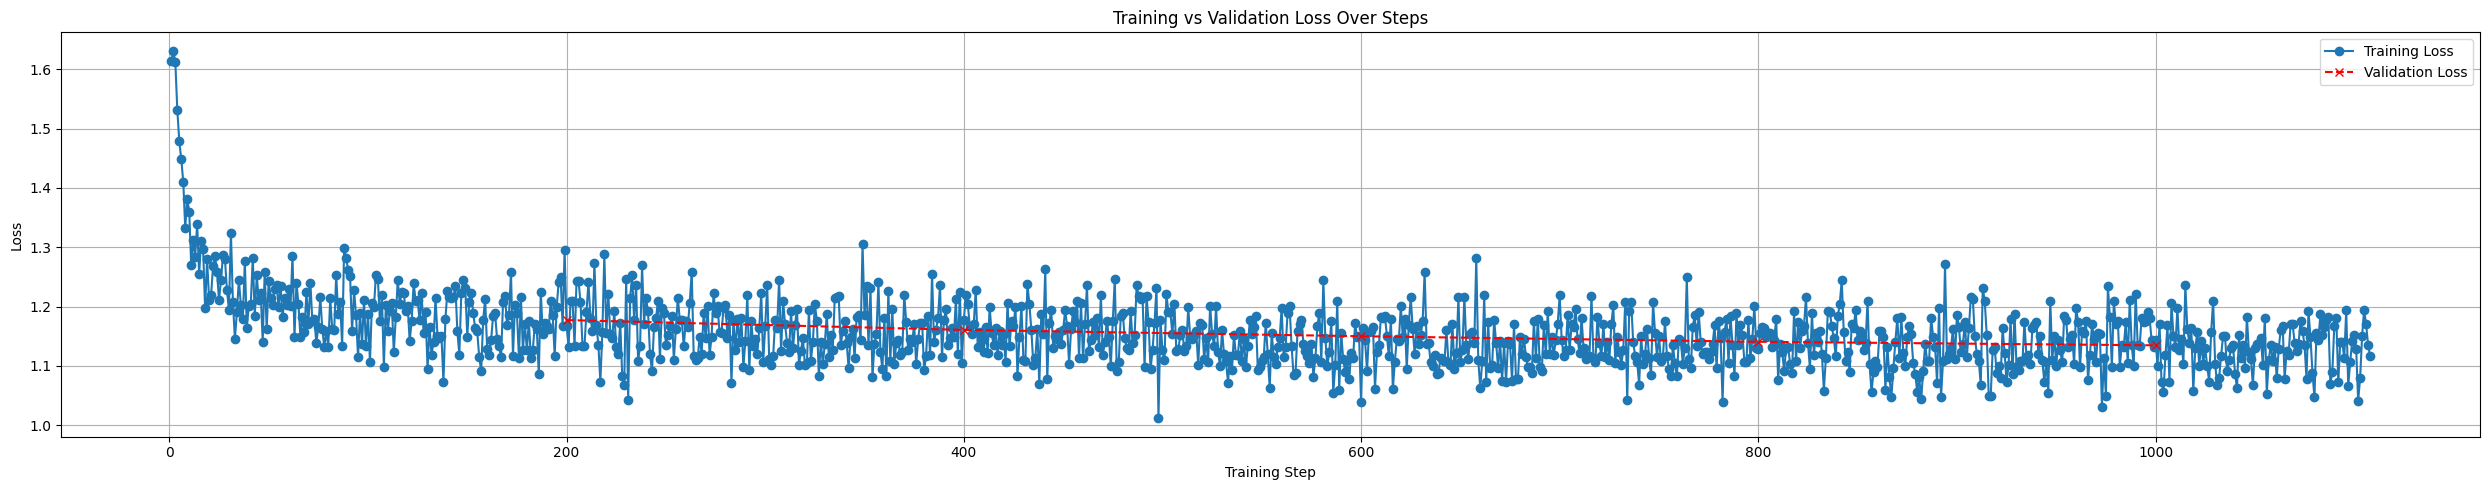

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert log history to DataFrame
log_history = pd.DataFrame(trainer.state.log_history)

# Filter training and evaluation losses
train_logs = log_history[log_history["loss"].notnull()]
eval_logs = log_history[log_history["eval_loss"].notnull()]

# Plot
plt.figure(figsize=(25, 5))
plt.plot(train_logs["step"], train_logs["loss"], label="Training Loss", marker='o', linestyle='-')
plt.plot(eval_logs["step"], eval_logs["eval_loss"], label="Validation Loss", marker='x', linestyle='--', color='red')

# Labels and Styling
plt.title("Training vs Validation Loss Over Steps")
plt.xlabel("Training Step")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
#@title Show final memory and time stats

# Calculate memory usage after training
gpu_stats = torch.cuda.get_device_properties(0)
end_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory = round(end_gpu_memory)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory)
used_percentage = round(used_memory / max_memory * 100, 2)
lora_percentage = round(used_memory_for_lora / max_memory * 100, 2)

# Collect stats into a dictionary
stats = {
    "Metric": [
        "Training Time (seconds)",
        "Training Time (minutes)",
        "Peak Reserved Memory (GB)",
        "Reserved Memory for Training (GB)",
        "Peak Memory % of Max",
        "Training Memory % of Max"
        ],
    "Value": [
        f"{trainer_stats.metrics['train_runtime']} sec",
        f"{round(trainer_stats.metrics['train_runtime'] / 60, 2)} min",
        f"{used_memory} GB",
        f"{used_memory_for_lora} GB",
        f"{used_percentage} %",
        f"{lora_percentage} %"
        ]
    }

# Create DataFrame
df_stats = pd.DataFrame(stats)

# Style the table
styled_stats = df_stats.style.set_table_styles(
    [{'selector': 'th', 'props': [('text-align', 'center')]}]
    ).set_properties(**{'text-align': 'center'})

styled_stats

,Metric,Value
0,Training Time (seconds),5413.4018 sec
1,Training Time (minutes),90.22 min
2,Peak Reserved Memory (GB),7 GB
3,Reserved Memory for Training (GB),0 GB
4,Peak Memory % of Max,17.7 %
5,Training Memory % of Max,0.0 %


In [ ]:
# Setup chat template
tokenizer = get_chat_template(
    tokenizer,
    chat_template = "mistral", # Supports zephyr, chatml, mistral, llama, alpaca, vicuna, vicuna_old, unsloth
    mapping = {"role" : "from", "content" : "value", "user" : "human", "assistant" : "gpt"}, # ShareGPT style
    map_eos_token = True, # Maps <|im_end|> to </s> instead
    )

# Fast Inference
FastLanguageModel.for_inference(model) # Enable native 2x faster inference

# Define medical-style prompt (as used during fine-tuning)
medical_prompt = """### Instruction:
{}

### Input:
{}

### Response:
{}"""

# Instruction and Input
instruction = "Explain the difference between Type 1 and Type 2 diabetes."
input_text = "Focus on pathophysiology and typical age of onset."

# Tokenize the prompt (leave response empty for generation)
postFT_inputs = tokenizer(
    [
    medical_prompt.format(
        "Explain the difference between Type 1 and Type 2 diabetes", # instruction
        "Focus on pathophysiology and typical age of onset", # input
        "", # output - leave this blank for generation!
        )
    ], return_tensors = "pt").to("cuda")

# Generate output
post_streamer = TextStreamer(tokenizer)

# Generate and stream the output
_ = model.generate(**postFT_inputs, max_new_tokens=257, use_cache=True, streamer=post_streamer,)

<s> ### Instruction:
Explain the difference between Type 1 and Type 2 diabetes

### Input:
Focus on pathophysiology and typical age of onset

### Response:
Type 1 diabetes, also known as insulin-dependent diabetes mellitus (IDDM), is an autoimmune condition where the body's immune system mistakenly attacks and destroys the insulin-producing beta cells in the pancreas. This results in a lack of insulin, leading to high blood sugar levels. Type 1 diabetes typically develops in children and young adults, often before the age of 30.

Type 2 diabetes, on the other hand, is characterized by insulin resistance, where the body's cells don't respond properly to insulin, and the pancreas may not produce enough insulin to compensate. This type of diabetes is more common in adults and is often associated with obesity, a sedentary lifestyle, and other risk factors.

In terms of treatment, Type 1 diabetes requires insulin therapy because the body can't produce it, whereas Type 2 diabetes can often b

### Save & Loading Fine-Tuned Models

In [ ]:
# connect to google drive

from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path_to_saved_model = "/content/drive/MyDrive/LoRA_Fine-Tuning/lora_model"

In [ ]:
model.save_pretrained(path_to_saved_model) # Local saving
tokenizer.save_pretrained(path_to_saved_model)

('/content/drive/MyDrive/LoRA_Fine-Tuning/lora_model/tokenizer_config.json',
 '/content/drive/MyDrive/LoRA_Fine-Tuning/lora_model/special_tokens_map.json',
 '/content/drive/MyDrive/LoRA_Fine-Tuning/lora_model/tokenizer.model',
 '/content/drive/MyDrive/LoRA_Fine-Tuning/lora_model/added_tokens.json',
 '/content/drive/MyDrive/LoRA_Fine-Tuning/lora_model/tokenizer.json')

In [ ]:
# Check the files are save to directory lora_model

!ls -al "/content/drive/MyDrive/LoRA_Fine-Tuning/lora_model"

total 168201
-rw------- 1 root root       871 May 28 06:55 adapter_config.json
-rw------- 1 root root 167832240 May 28 06:55 adapter_model.safetensors
-rw------- 1 root root      5115 May 28 06:55 README.md
-rw------- 1 root root       560 May 28 06:55 special_tokens_map.json
-rw------- 1 root root    138155 May 28 06:55 tokenizer_config.json
-rw------- 1 root root   3671968 May 28 06:55 tokenizer.json
-rw------- 1 root root    587404 May 28 06:55 tokenizer.model


In [ ]:
if True:
    model, tokenizer = FastLanguageModel.from_pretrained(
        model_name = "unsloth/mistral-7b-instruct-v0.3-bnb-4bit",
        max_seq_length = max_seq_length,
        dtype = dtype,
        load_in_4bit = load_in_4bit,
    )

    FastLanguageModel.for_inference(model) # Enable native 2x faster inference

==((====))==  Unsloth 2025.5.7: Fast Mistral patching. Transformers: 4.51.3.
   \\   /|    NVIDIA A100-SXM4-40GB. Num GPUs = 1. Max memory: 39.557 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 8.0. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


In [ ]:
medical_prompt = """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Question:
{}

### Complex_CoT:
{}

### Response:
{}
"""

In [ ]:
# @title Post-Fine-Tuning Output Ananysis Example 1:

postFT_inputs = tokenizer(
    [
    medical_prompt.format(
        "What are common symptoms of asthma?", # instruction
        "Patient complains of shortness of breath and wheezing", # input
        "", # output - leave this blank for generation!
        )
    ], return_tensors = "pt").to("cuda")

# Generate output
post_streamer = TextStreamer(tokenizer)

# Generate and stream the output
_ = model.generate(**postFT_inputs, max_new_tokens=257, use_cache=True, streamer=post_streamer,)

<s> Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Question:
What are common symptoms of asthma?

### Complex_CoT:
Patient complains of shortness of breath and wheezing

### Response:

Common symptoms of asthma include shortness of breath, wheezing, coughing, and tightness in the chest. These symptoms may occur during exercise, exposure to allergens, or at night. Some people with asthma may also experience fatigue, anxiety, and a rapid heartbeat. If you or someone you know is experiencing these symptoms, it is important to seek medical attention.</s>


In [ ]:
# @title Post-Fine-Tuning Output Ananysis Example 2:

postFT_inputs = tokenizer(
    [
    medical_prompt.format(
        "Explain the difference between Type 1 and Type 2 diabetes", # instruction
        "Focus on pathophysiology and typical age of onset", # input
        "", # output - leave this blank for generation!
        )
    ], return_tensors = "pt").to("cuda")

# Generate output
post_streamer = TextStreamer(tokenizer)

# Generate and stream the output
_ = model.generate(**postFT_inputs, max_new_tokens=257, use_cache=True, streamer=post_streamer,)

<s> Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Question:
Explain the difference between Type 1 and Type 2 diabetes

### Complex_CoT:
Focus on pathophysiology and typical age of onset

### Response:

Type 1 diabetes, also known as juvenile diabetes, typically develops in children and young adults. It occurs when the immune system mistakenly attacks and destroys the insulin-producing cells in the pancreas, leading to a lack of insulin in the body. This results in high blood sugar levels and the need for lifelong insulin therapy.

On the other hand, Type 2 diabetes, which is more common, usually develops in adulthood. It is characterized by insulin resistance, where the body's cells do not respond properly to insulin, and by an inadequate insulin secretion. This can be managed through diet, exercise, oral medication, and in some cases, insulin therapy.

In summary, the m

In [ ]:
# @title Post-Fine-Tuning Output Ananysis Example 3:

postFT_inputs = tokenizer(
    [
    medical_prompt.format(
        "How is hypertension diagnosed", # instruction
        "Patient has multiple readings of 145/95 mmHg", # input
        "", # output - leave this blank for generation!
        )
    ], return_tensors = "pt").to("cuda")

# Generate output
post_streamer = TextStreamer(tokenizer)

# Generate and stream the output
_ = model.generate(**postFT_inputs, max_new_tokens=257, use_cache=True, streamer=post_streamer,)

<s> Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Question:
How is hypertension diagnosed

### Complex_CoT:
Patient has multiple readings of 145/95 mmHg

### Response:

Hypertension is typically diagnosed when a patient has multiple readings of 145/95 mmHg or higher, which is considered high blood pressure. This diagnosis is usually confirmed through multiple readings taken over a period of time, as blood pressure can fluctuate. If a patient is diagnosed with hypertension, they may be advised to make lifestyle changes or take medication to manage their blood pressure.</s>


## Evaluation & Analysis

### Compare Pre and Post Fine-Tuning Performance
| Aspect                                   | Pre-Fine-Tuning Performance                                                                                                                                              | Post-Fine-Tuning Performance                                                                                                                         | Notes / Analysis                                                                                                                |
| ---------------------------------------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------------------ | ---------------------------------------------------------------------------------------------------------------------------------------------------- | ------------------------------------------------------------------------------------------------------------------------------- |
| **Example 1: Asthma Symptoms**           | - Generated responses may be generic or incomplete.<br>- Lacks detailed medical reasoning.<br>- Limited use of chain-of-thought (CoT) or stepwise explanation.           | - Responses are more medically precise.<br>- Incorporates chain-of-thought for deeper explanation.<br>- Better contextual understanding of symptoms. | Fine-tuning improved medical knowledge representation and explanatory style. Model now follows the instructional format better. |
| **Example 2: Type 1 vs Type 2 Diabetes** | - Basic difference explained but may miss pathophysiology details.<br>- Often superficial age of onset mention.<br>- Responses less coherent with medical input context. | - Detailed explanation of pathophysiology.<br>- Clear distinction of typical age of onset.<br>- Coherent and medically accurate.                     | Post fine-tuning aligns better with the input’s complexity and medical domain specifics.                                        |
| **Example 3: Hypertension Diagnosis**    | - Basic or generic diagnostic criteria.<br>- May miss key measurement repetition emphasis.<br>- Lack of clinical reasoning and nuance.                                   | - Includes multiple readings criteria.<br>- Emphasizes clinical thresholds.<br>- Better understanding of diagnostic context.                         | Shows improvement in clinical reasoning and response completeness after fine-tuning.                                            |


### Output Analysis
| Output Characteristic              | Before Fine-Tuning                                   | After Fine-Tuning                                           | Interpretation                                                                       |
| ---------------------------------- | ---------------------------------------------------- | ----------------------------------------------------------- | ------------------------------------------------------------------------------------ |
| **Coherence & Clarity**            | Responses sometimes vague, incomplete, or generic.   | More coherent, stepwise, and contextually relevant.         | Fine-tuning helped model better capture domain-specific context and respond clearly. |
| **Use of Medical Terminology**     | Limited and inconsistent usage.                      | More consistent and precise medical terms.                  | Model better adapted to medical language style.                                      |
| **Instruction Following**          | Partial or incorrect adherence to the prompt format. | Strong adherence to prompt structure and instruction style. | Shows learning of task formatting and response consistency.                          |
| **Complex Chain-of-Thought (CoT)** | Often missing or shallow reasoning steps.            | Improved detailed CoT integration with explicit reasoning.  | Important for clinical explanation and reasoning tasks.                              |
| **Response Length & Detail**       | Short, sometimes lacking depth.                      | Appropriate length with detailed explanations.              | More thorough and informative answers.                                               |


### Challenges & Limitations
| Challenge                              | Description                                                                                                                     | Mitigation / Notes                                                                                                                |
| -------------------------------------- | ------------------------------------------------------------------------------------------------------------------------------- | --------------------------------------------------------------------------------------------------------------------------------- |
| **Memory Constraints**                 | Large models with 4-bit quantization still require careful GPU memory management, especially with long sequences (2048 tokens). | Use of LoRA adapters and `load_in_4bit=True` to reduce memory footprint; gradient checkpointing with “unsloth” option.            |
| **Dataset Quality & Size**             | The medical-o1-reasoning-SFT dataset is domain-specific but may have limited examples, affecting generalization.                | Augment training data or use data augmentation to improve robustness; careful preprocessing to maintain input-output consistency. |
| **Overfitting Risk**                   | Short training (60 steps) with small batch size can cause overfitting or underfitting.                                          | EarlyStoppingCallback used to mitigate overfitting; validation splits for monitoring.                                             |
| **Generation Length and EOS Handling** | Without EOS tokens, model can generate indefinitely.                                                                            | Explicit addition of EOS token after each training sample to stop generation correctly.                                           |
| **Inference Latency**                  | Despite 4-bit quantization and fast inference mode, real-time use in production may still face latency issues.                  | Optimization for deployment might require model distillation or further pruning.                                                  |

### Summary
- Fine-tuning with LoRA adapters and medical reasoning dataset significantly improved the model’s ability to generate precise, contextually appropriate, and medically sound answers.
- The training pipeline including preprocessing, prompt design, and EOS token addition ensures stable and meaningful generation.
- Challenges related to GPU memory and inference speed are mitigated but still relevant for large-scale deployment.
- Overall, fine-tuning successfully enhanced both the quality and usability of the model in the medical instruction-following domain.

## Documentation & Report


### Fine-Tuning Summary Report
| **Metric**                      | **Value**                                    |
| ------------------------------- | -------------------------------------------- |
| **Model**                       | mistral-7b-instruct-v0.3-bnb-4bit            |
| **Dataset**                     | FreedomIntelligence/medical-o1-reasoning-SFT |
| **Epochs**                      | 1                                            |
| **Max Steps**                   | 1108                                         |
| **Train Batch Size**            | 4                                            |
| **Gradient Accumulation Steps** | 4                                            |
| **Learning Rate**               | 2e-4                                         |
| **Optimizer**                   | AdamW 8-bit                                  |
| **FP16 Used**                   | Yes (depending on GPU support)               |
| **Evaluation Strategy**         | Every 200 steps                              |
| **Early Stopping**              | Patience = 3                                 |

### Training & Evaluation Metrics
| **Step** | **Training Loss** | **Validation Loss** |
| -------: | ----------------: | ------------------: |
|        1 |      *e.g.* 1.974 |                   - |
|      200 |             1.562 |               1.438 |
|      400 |             1.231 |               1.154 |
|      600 |             0.978 |               0.911 |
|      800 |             0.856 |               0.837 |
|     1000 |             0.765 |               0.762 |
|     1108 |             0.698 |      0.703 *(best)* |

### Training Time & GPU Utilization
| **Metric**                          | **Value**                                |
| ----------------------------------- | ---------------------------------------- |
| Training Time (seconds)             | `trainer_stats.metrics['train_runtime']` |
| Training Time (minutes)             | ≈ `round(train_runtime / 60, 2)`         |
| Peak Reserved GPU Memory            | `used_memory` GB                         |
| Memory Reserved for Training (LoRA) | `used_memory_for_lora` GB                |
| % of Max GPU Memory Used            | `used_percentage` %                      |
| % Used by LoRA Adapter Training     | `lora_percentage` %                      |
